<a href="https://colab.research.google.com/github/Bisalia/Bayesian_network/blob/main/zadanie2_pzmo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Кебеков Тимур

Данные https://drive.google.com/file/d/1loZVxXSdUGxkiNkbMoMBxGxIcrB3v0Gk/view?usp=sharing


# 1. Добавить в решение ДЗ 1 псевдолейблинг, сравнить результаты с лучшим из имеющихся классификаторов (можно сделать разделение train-test-val)

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.metrics import classification_report

from tempfile import TemporaryDirectory
import zipfile

import time
import copy

import os
import random

from google.colab import drive

from scipy import stats


In [ ]:
%matplotlib inline

In [ ]:
# подключаем Google Drive
drive.mount('/content/drive')

# путь к файлу на Google Drive
file_path = '/content/drive/MyDrive/one_piece.zip'

Mounted at /content/drive


In [ ]:
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/one_piece')

In [ ]:
seed = 1000

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
input_folder_path = '/content/one_piece/Data/Data'

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_no_aug = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

transform_aug = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.15),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomInvert(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

full_dataset = ImageFolder(input_folder_path)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(seed))

train_dataset_aug = copy.deepcopy(train_dataset)

train_dataset.dataset.transform = transform_no_aug
train_dataset_aug.dataset.transform = transform_aug
test_dataset.dataset.transform = transform_no_aug


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}

In [ ]:
class_names = full_dataset.classes
class_names

['Ace',
 'Akainu',
 'Brook',
 'Chopper',
 'Crocodile',
 'Franky',
 'Jinbei',
 'Kurohige',
 'Law',
 'Luffy',
 'Mihawk',
 'Nami',
 'Rayleigh',
 'Robin',
 'Sanji',
 'Shanks',
 'Usopp',
 'Zoro']

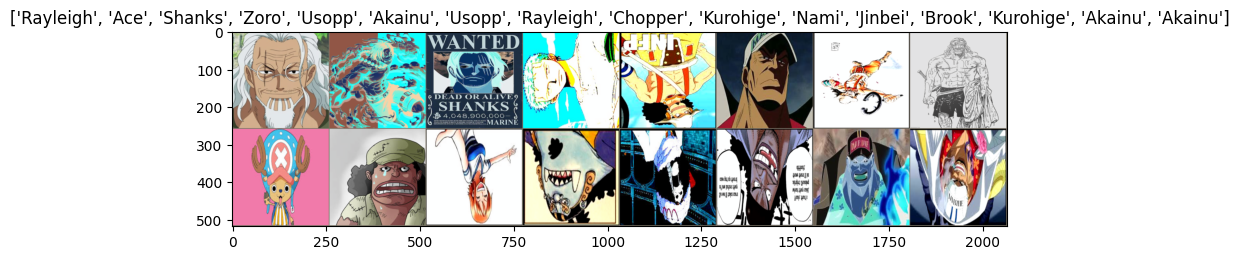

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


inputs, classes = next(iter(test_loader))

out = make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [ ]:
def stat(model): #Вычисляет матрицу ошибок

  # Инициализация матрицы ошибок
  confusion_matrix = torch.zeros(18, 18)
   # Отключение градиентов для вычислений
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(test_loader):
          inputs = inputs.to(device)
          classes = classes.to(device)
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          # Обновление матрицы ошибок на основе предсказанных классов и истинных классов
          for t, p in zip(classes.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1

  return(confusion_matrix)


def conf_m(m):

    df_cm = pd.DataFrame(m, index=class_names, columns=class_names).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show();

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=8, aug=False, unfreeze=True):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        acc = {'train': [], 'test': []}
        losses = {'train': [], 'test': []}

        for param in model.parameters():
            param.requires_grad = False


        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
            if unfreeze:

                if epoch == 0:
                    # Размораживаем только layer4
                    for param in model.layer4.parameters():
                        param.requires_grad = True
                elif epoch == 1:
                    # Размораживаем layer4 и layer3
                    for param in model.layer3.parameters():
                        param.requires_grad = True
                elif epoch == 2:
                    # Размораживаем layer4, layer3 и layer2
                    for param in model.layer2.parameters():
                        param.requires_grad = True

                else:
                    # Размораживаем все слои
                    for param in model.parameters():
                        param.requires_grad = True


            else:
                # без итеративной разморозки
                for param in model.parameters():
                    param.requires_grad = True


            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0
                true_labels = []
                pred_labels = []


                dataloaders = {'train': train_loader, 'test': test_loader}

                if aug and phase == 'train':
                    if epoch % 2 == 0:
                        dataloaders['train'] = train_loader_aug

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    true_labels.extend(labels.cpu().numpy())
                    pred_labels.extend(preds.cpu().numpy())


                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                class_report = classification_report(true_labels, pred_labels)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                print(class_report)

                acc[phase].append(epoch_acc.item())
                losses[phase].append(epoch_loss)

                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best test Acc: {best_acc:4f}')
        conf_matrix = stat(model)

        model.load_state_dict(torch.load(best_model_params_path))

        return model, losses, acc, best_acc,conf_matrix


In [ ]:
def visualize_model(model, num_images=9):

    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            plt.figure(figsize=(10,8))

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 3, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j].item()]}')

                image = inputs[j].cpu().numpy().transpose((1, 2, 0))
                image = std * image + mean
                image = np.clip(image, 0, 1)

                plt.imshow(image)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

            model.train(mode=was_training)

In [ ]:
def plot_loss(acc, losses):
    fig, axs = plt.subplots(1, 2,  figsize=(14,4))
    axs[0].plot(acc['train'],label='train acc')
    axs[0].plot(acc['test'],label='test acc')
    axs[0].legend()

    axs[1].plot(losses['train'],label='train loss')
    axs[1].plot(losses['test'],label='test loss')
    axs[1].legend()
    plt.show()

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1=nn.Linear(2048, 18)

    def forward(self,x):
        x = self.linear1(x)  # только для fc слоя, для остальных слоев forward реснета
        return x


def create_model(unfreeze=False, optimizer='SGD'):
    resnet = models.resnet152(weights="ResNet152_Weights.IMAGENET1K_V1").to(device)
    fc_ = Classifier().to(device)
    resnet.fc = fc_

    for param in resnet.fc.parameters():
        param.requires_grad = True

    if optimizer == 'SGD':
        optimizer_ft= optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
    else:
        optimizer_ft = optim.Adam(resnet.parameters(), lr=0.001)

    exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)
    loss_fn = nn.CrossEntropyLoss()

    return resnet, optimizer_ft, exp_lr_scheduler, loss_fn



#### Обучение на тренировочной выборке

In [ ]:
model4, optimizer4, scheduler4,  loss_fn = create_model()
model4, losses4, acc4, best_acc4, matrix4 = train_model(model4, loss_fn, optimizer4, scheduler4, num_epochs=5, unfreeze=False, aug=True)

In [ ]:
print('Точность', float(best_acc4))

Точность 0.9914821124361158


#### Обучение на размеченных данных из теста

In [ ]:
high_confidence_data = []
high_confidence_labels = []

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model4(inputs)
    probabilities = torch.softmax(outputs, dim=1)
    confident_indices = torch.max(probabilities, dim=1)[0] > 0.96
    confident_inputs = inputs[confident_indices]
    confident_labels = labels[confident_indices]

    high_confidence_data.append(confident_inputs)
    high_confidence_labels.append(confident_labels)

high_confidence_data = torch.cat(high_confidence_data)
high_confidence_labels = torch.cat(high_confidence_labels)


In [ ]:
high_confidence_dataset = TensorDataset(high_confidence_data, high_confidence_labels)
train_loader  = DataLoader(high_confidence_dataset, batch_size=16, shuffle=True)

In [ ]:
model40, losses_resampled, acc_resampled, best_acc_resampled, matrix_resampled = train_model(model4, loss_fn, optimizer4, scheduler4, num_epochs=3, unfreeze=False, aug=True)

In [ ]:
print('Точность', float(best_acc_resampled))

Точность 0.9931856899488927


# 2. Придумать 3 отличающихся от рассказанных на занятии метрики качества поиска (во всем многообразии элементов поисковой выдачи) и объяснить, почему их можно брать в качестве основных для оценки качества.

* Процент пользователей которые перешли по выданным ссылкам, можно брать так как по сути, это можно интерпретировать как доверие пользователя
* Метрика которая оценивает различность результатов выдачи, то есть здесь важно что бы результат не был абсолютно одинаковым, если пользователь не ищет что-то конкретное, а просто хочет больше узнать о предмете запроса.
* Метрика, которая оценивает степень релевантности результатов поиска для конкретного пользователя на осного его прошлой истории. Можно брать так как учитывает индивуальные потребности пользователя
* Обратная связь от пользователей, кажется самой очевидной


# 3. Придумать 3 отличающихся от рассказанных на занятии метода улучшения качества разметки релевантности и объяснить, как именно они улучшат качество.

* Модель будет размечать не все данные, а самые простые для нее, остальные случаю будут размечать специальные люди. Это позволит уменьшить время на ручную разметку, но при этом будет иметь высокую точность.

* Использование ансамбля моделей для разметки улучшит качество.

* Использовать модели адаптированные для различных языков.

#4.  Рассчитать p-value гипотезы "выдача google по запросу <выберите любой запрос> статистически значимо лучше, чем выдача yandex по этому же запросу". Оценку релевантности всех страниц выдачи, а также уровень значимости (порог, при котором мы отвергаем гипотезу) провести самостоятельно.

### Запрос -- Почему Гослинг стал мемом

In [ ]:
from scipy import stats
import numpy as np

In [ ]:
google = np.array([3, 3, 2, 2, 2, 1, 1, 1])
yandex = np.array([3, 3, 3, 3, 2, 2, 2, 1])

In [ ]:
print('Среднее по гуглу', google.mean())
print('Среднее по яндексу', yandex.mean())


Среднее по гуглу 1.875
Среднее по яндексу 2.375


In [ ]:
# Проверка на нормальность распределений
statistic1, p_value_g = stats.shapiro(google)
statistic2, p_value_y = stats.shapiro(yandex)

if p_value_g < 0.05:
    print("Распределение google не распределено нормально", p_value_g)
if p_value_y < 0.05:
    print("Распределение yandex не распределено нормально", p_value_y)

Распределение yandex не распределено нормально 0.02696797251701355


In [ ]:
t_statistic, p_value = stats.mannwhitneyu(google, yandex) #распределение не нормальное, выборка маленькая, поэтому непараметрический критерий
print(p_value)
if p_value < 0.05:
    print("Средние значения выборок значимо отличаются")
else:
    print("Средние значения выборок не отличаются значимо")


0.24042078636843534
Средние значения выборок не отличаются значимо


Но по ощущениям выдача яндекса кажется лучше